In [1]:
%load_ext rpy2.ipython
%xmode Plain

Exception reporting mode: Plain


In [2]:
%%R
library(tidyverse)
library(ggpubr)
library(phyloseq)
library(readxl)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Prepare data

### Taxonomic profile

In [3]:
%%R
tax_file <- "data/metaphlan3.merged.abundance.profile.species.272S.tsv"
tax_s <- read_tsv(tax_file)
tax_s_l <-
    tax_s %>%
    rowwise() %>%
    mutate(Species=str_split(clade_name, "\\|s__")[[1]][2]) %>%
    ungroup() %>%
    pivot_longer(
        names_to="sample_id",
        values_to="Abundance",
        -c(clade_name, Species))

dim(tax_s_l)

Rows: 547 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 148784      4


In [271]:
%%R
tax_file_p <- "data/metaphlan3.merged.abundance.profile.phylum.272S.tsv"
tax_p <- read_tsv(tax_file_p)
tax_p_l <-
    tax_p %>%
    rowwise() %>%
    mutate(Phylum=str_split(clade_name, "\\|p__")[[1]][2]) %>%
    ungroup() %>%
    pivot_longer(
        names_to="sample_id",
        values_to="Abundance",
        -c(clade_name, Phylum))

dim(tax_p_l)

Rows: 12 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 3264    4


In [5]:
%%R
547 * 272

[1] 148784


### Metadata

In [236]:
%%R
samples_metadata <-
    read_tsv("metadata/samples_metadata_imm_272S.tsv")
    

paired_ID <- count(samples_metadata, ID) %>% filter(n==2) %>% select(ID) %>% as.list()

samples_metadata_paired <-
    samples_metadata %>% filter(ID %in% paired_ID$ID)

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
%%R
samples_metadata_ae <-
    read_tsv("metadata/samples_metadata_imm_ae_138S.tsv")

Rows: 275 Columns: 93
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (85): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [208]:
%%R
length(unique(samples_metadata_ae$sample_id))

[1] 138


In [7]:
%%R
colnames(samples_metadata_ae)

 [1] "sample_id"                     "ID"                           
 [3] "TimePoint"                     "Cohort"                       
 [5] "all_bray_cluster3"             "Vac_Group"                    
 [7] "Age"                           "Male"                         
 [9] "BMI"                           "OWOB"                         
[11] "Obese_bin"                     "HTC_bin"                      
[13] "DMC_bin"                       "Allergies_ever_bin"           
[15] "Diarrhea_within_past_3_months" "Any_other_como_bin"           
[17] "Antibiotics_3m_current"        "Hormone_current"              
[19] "Immunosuppressant_current"     "Probiotic_current"            
[21] "Vaccines_received_past_year"   "Dietary_preference"           
[23] "Dietary_change"                "Alcohol_drinking_past_2w"     
[25] "Regular_exercise"              "M0_RBD"                       
[27] "M1_RBD_100"                    "AUC_100_12800"                
[29] "M1_sVNT_10"                 

In [8]:
%%R
samples_metadata_ae$VAC_DOSE

  [1]  1  2  1  2 NA  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
 [26]  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
 [51]  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
 [76]  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
[101]  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
[126]  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
[151]  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
[176]  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
[201]  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2
[226]  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1
[251]  2  1  2  1  2  1  2  2  1  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2


### Merge tax profile and metadata

In [9]:
%%R
tax_s_l_ae <- tax_s_l %>% inner_join(samples_metadata_ae)

Joining, by = "sample_id"


In [ ]:
%%R
dim(tax_s_l_ae)

[1] 150425     96


In [11]:
%%R
137 * 547 * 2 + 1 * 547 * 1

[1] 150425


In [296]:
%%R
tax_s_l_272S <- tax_s_l %>% inner_join(samples_metadata)

Joining, by = "sample_id"


In [297]:
%%R
dim(tax_s_l_272S)

[1] 148784     60


In [298]:
%%R
272 * 547

[1] 148784


In [247]:
%%R
tax_s_l_268S <- tax_s_l %>% inner_join(samples_metadata_paired)

Joining, by = "sample_id"


In [273]:
%%R
tax_p_l_268S <- tax_p_l %>% inner_join(samples_metadata_paired)

Joining, by = "sample_id"


In [248]:
%%R
dim(tax_s_l_268S)

[1] 146596     60


In [242]:
%%R
547 * 268

[1] 146596


## LEfSe analysis

In [338]:
%%R
tax_s_lefse <- tax_s_l_268S %>%
    filter(Vac_Group=="BioNTech") %>%
    select(sample_id, Species, Abundance, TimePoint) %>%
    mutate(Time_Point=case_when(
        TimePoint=="D0" ~ 0,
        TimePoint=="M1" ~ 1
    )) %>%
    select(-TimePoint) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()

tax_s_lefse_2 <-
    tax_s_lefse %>%
    select(sample_id, Time_Point) %>%
    distinct() %>%
    mutate(Species="Time_Point") %>%
    rename(Abundance=Time_Point)
    
tax_s_lefse_w <-
    tax_s_lefse_2 %>%
    bind_rows(
        tax_s_lefse %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_s_lefse_w, "../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.tsv")

[1] 508 197


In [339]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.lefse.out.tsv

Number of significantly discriminative features: 39 ( 39 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 26
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [340]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 507 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [341]:
%%R
biontech_d0_species <- lefse %>% filter(group==0) %>% select(Species) %>% as.list()

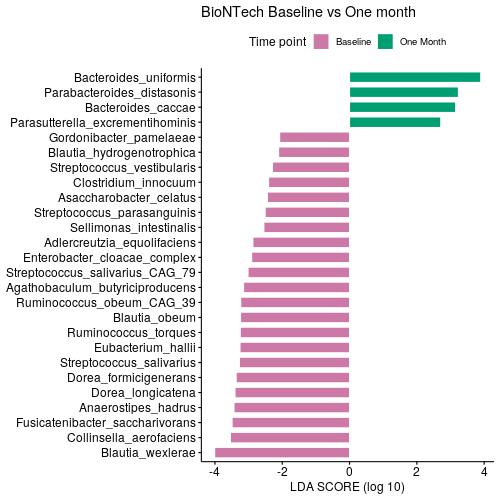

In [342]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "Time point") +
ylab("LDA SCORE (log 10)") +
ggtitle("BioNTech Baseline vs One month") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Baseline", "One Month"),
                  values=c("0"="#CC79A7", "1"="#009E73"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_biontech_timepoint.pdf", p, width=8, height=8)

In [343]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_biontech_timepoint_abun.tsv")

Joining, by = "Species"
# A tibble: 26 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Adlercreutzia_…    0.000726               0         0                0.000726
 2 Agathobaculum_…    0.00458                0         0.00224          0.00458 
 3 Anaerostipes_h…    0.00857                0         0.00305          0.00857 
 4 Asaccharobacte…    0.000204               0         0                0.000204
 5 Bacteroides_ca…    0.00149                0         0                0.00149 
 6 Bacteroides_un…    0.0318                 0         0.0101           0.0318  
 7 Blautia_hydrog…    0                      0         0                0       
 8 Blautia_obeum      0.00156                0         0.000460         0.00156 
 9 Blautia_wexler…    0.0137                 0         0.00649          0.0137  
10 Clostridium_in…    0                      0         0         

In [344]:
%%R
tax_s_lefse <- tax_s_l_268S %>%
    filter(Vac_Group=="SinoVac") %>%
    select(sample_id, Species, Abundance, TimePoint) %>%
    mutate(Time_Point=case_when(
        TimePoint=="D0" ~ 0,
        TimePoint=="M1" ~ 1
    )) %>%
    select(-TimePoint) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()

tax_s_lefse_2 <-
    tax_s_lefse %>%
    select(sample_id, Time_Point) %>%
    distinct() %>%
    mutate(Species="Time_Point") %>%
    rename(Abundance=Time_Point)
    
tax_s_lefse_w <-
    tax_s_lefse_2 %>%
    bind_rows(
        tax_s_lefse %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_s_lefse_w, "../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.tsv")

[1] 381  73


In [345]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.lefse.out.tsv

Number of significantly discriminative features: 21 ( 21 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 12
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [346]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 380 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [347]:
%%R
sinovac_d0_species <- lefse %>% filter(group==0) %>% select(Species) %>% as.list()

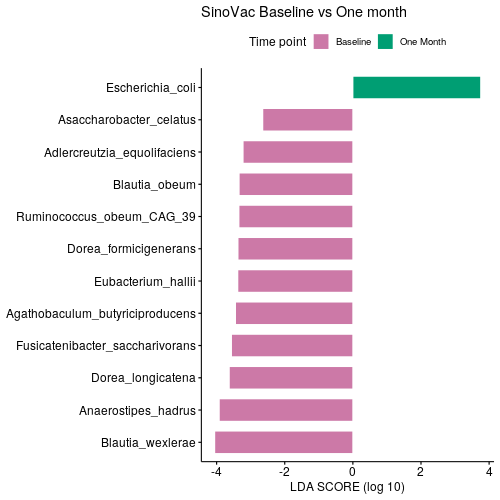

In [348]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "Time point") +
ylab("LDA SCORE (log 10)") +
ggtitle("SinoVac Baseline vs One month") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Baseline", "One Month"),
                  values=c("0"="#CC79A7", "1"="#009E73"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_sinovac_timepoint.pdf", p, width=8, height=8)

In [349]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_sinovac_timepoint_abun.tsv")

Joining, by = "Species"
# A tibble: 12 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Adlercreutzia_…    0.000578        0               0.0000476         0.000578
 2 Agathobaculum_…    0.00500         0               0.00182           0.00500 
 3 Anaerostipes_h…    0.00927         0               0.00225           0.00927 
 4 Asaccharobacte…    0.000159        0               0                 0.000159
 5 Blautia_obeum      0.00143         0               0.000447          0.00143 
 6 Blautia_wexler…    0.0137          0.000673        0.00593           0.0137  
 7 Dorea_formicig…    0.00256         0               0.00117           0.00256 
 8 Dorea_longicat…    0.00397         0               0.000627          0.00397 
 9 Escherichia_co…    0.000648        0               0                 0.000648
10 Eubacterium_ha…    0.00468         0.000157        0.00186    

In [ ]:
##

In [350]:
%%R
biontech_d0_species$Species

 [1] "Collinsella_aerofaciens"         "Adlercreutzia_equolifaciens"    
 [3] "Asaccharobacter_celatus"         "Gordonibacter_pamelaeae"        
 [5] "Streptococcus_parasanguinis"     "Streptococcus_salivarius"       
 [7] "Streptococcus_salivarius_CAG_79" "Streptococcus_vestibularis"     
 [9] "Eubacterium_hallii"              "Anaerostipes_hadrus"            
[11] "Blautia_hydrogenotrophica"       "Blautia_obeum"                  
[13] "Blautia_wexlerae"                "Ruminococcus_torques"           
[15] "Dorea_formicigenerans"           "Dorea_longicatena"              
[17] "Fusicatenibacter_saccharivorans" "Sellimonas_intestinalis"        
[19] "Agathobaculum_butyriciproducens" "Ruminococcus_obeum_CAG_39"      
[21] "Clostridium_innocuum"            "Enterobacter_cloacae_complex"   


In [351]:
%%R
intersect(biontech_d0_species$Species, sinovac_d0_species$Species)

 [1] "Adlercreutzia_equolifaciens"     "Asaccharobacter_celatus"        
 [3] "Eubacterium_hallii"              "Anaerostipes_hadrus"            
 [5] "Blautia_obeum"                   "Blautia_wexlerae"               
 [7] "Dorea_formicigenerans"           "Dorea_longicatena"              
 [9] "Fusicatenibacter_saccharivorans" "Agathobaculum_butyriciproducens"
[11] "Ruminococcus_obeum_CAG_39"      


In [ ]:
##

In [352]:
%%R
tax_p_l_268S %>% head()

# A tibble: 6 × 60
  clade_name  Phylum sample_id Abundance ID    TimePoint Cohort all_bray_cluste…
  <chr>       <chr>  <chr>         <dbl> <chr> <chr>     <chr>             <dbl>
1 k__Archaea… Eurya… VAC003B-…         0 VAC0… M1        CUHK                  3
2 k__Archaea… Eurya… VAC005B-…         0 VAC0… M1        CUHK                  3
3 k__Archaea… Eurya… VAC007B-…         0 VAC0… M1        CUHK                  3
4 k__Archaea… Eurya… VAC010B-…         0 VAC0… M1        CUHK                  3
5 k__Archaea… Eurya… VAC011S-…         0 VAC0… M1        CUHK                  1
6 k__Archaea… Eurya… VAC012B-…         0 VAC0… M1        CUHK                  1
# … with 52 more variables: Vac_Group <chr>, Age <dbl>, Male <dbl>, BMI <dbl>,
#   OWOB <dbl>, Obese_bin <dbl>, HTC_bin <dbl>, DMC_bin <dbl>,
#   Allergies_ever_bin <dbl>, Diarrhea_within_past_3_months <dbl>,
#   Any_other_como_bin <dbl>, Antibiotics_3m_current <dbl>,
#   Hormone_current <dbl>, Immunosuppressant_current <dbl>,
#   

In [353]:
%%R
tax_p_lefse <- tax_p_l_268S %>%
    filter(Vac_Group=="BioNTech") %>%
    select(sample_id, Phylum, Abundance, TimePoint) %>%
    mutate(Time_Point=case_when(
        TimePoint=="D0" ~ 0,
        TimePoint=="M1" ~ 1
    )) %>%
    select(-TimePoint) %>%
    group_by(Phylum) %>%
    mutate(Phylum_abun_sum=sum(Abundance)) %>%
    filter(!Phylum_abun_sum<=0.0) %>%
    select(-Phylum_abun_sum) %>%
    ungroup()

tax_p_lefse_2 <-
    tax_p_lefse %>%
    select(sample_id, Time_Point) %>%
    distinct() %>%
    mutate(Phylum="Time_Point") %>%
    rename(Abundance=Time_Point)
    
tax_p_lefse_w <-
    tax_p_lefse_2 %>%
    bind_rows(
        tax_p_lefse %>%
        select(sample_id, Phylum, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_p_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_p_lefse_w, "../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.tsv")

[1]  13 197


In [354]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.tsv \
../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.lefse.in \
../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.lefse.out.tsv

Number of significantly discriminative features: 4 ( 4 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 4
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [355]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_w.lefse.out.tsv",
             col_names=c("Phylum", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 12 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Phylum, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


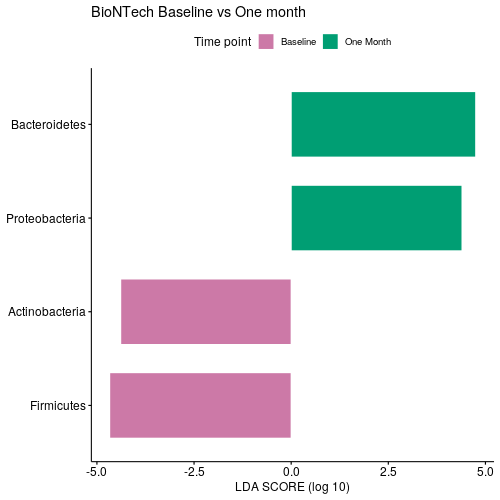

In [356]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Phylum", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "Time point") +
ylab("LDA SCORE (log 10)") +
ggtitle("BioNTech Baseline vs One month") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Baseline", "One Month"),
                  values=c("0"="#CC79A7", "1"="#009E73"))

print(p)
ggsave("../results/figures/V1/lefse/phylum_lefse_biontech_timepoint.pdf", p, width=8, height=8)

In [357]:
%%R
tax_p_lefse_summary <-
    tax_p_lefse %>% group_by(Phylum) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_p_enrichment <- tax_p_lefse_summary %>% right_join(lefse)
print(tax_p_enrichment)
write_tsv(tax_p_enrichment, "../results/tables/V1/lefse/tax_p_lefse_biontech_timepoint_abun.tsv")

Joining, by = "Phylum"
# A tibble: 4 × 11
  Phylum         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                <dbl>           <dbl>            <dbl>            <dbl>
1 Actinobacteria      0.0587       0.00209            0.0263            0.0587
2 Bacteroidetes       0.351        0.00138            0.199             0.351 
3 Firmicutes          0.512        0.105              0.358             0.512 
4 Proteobacteria      0.0171       0.0000559          0.00630           0.0171
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, p.value <chr>


In [358]:
%%R
tax_p_lefse <- tax_p_l_268S %>%
    filter(Vac_Group=="SinoVac") %>%
    select(sample_id, Phylum, Abundance, TimePoint) %>%
    mutate(Time_Point=case_when(
        TimePoint=="D0" ~ 0,
        TimePoint=="M1" ~ 1
    )) %>%
    select(-TimePoint) %>%
    group_by(Phylum) %>%
    mutate(Phylum_abun_sum=sum(Abundance)) %>%
    filter(!Phylum_abun_sum<=0.0) %>%
    select(-Phylum_abun_sum) %>%
    ungroup()

tax_p_lefse_2 <-
    tax_p_lefse %>%
    select(sample_id, Time_Point) %>%
    distinct() %>%
    mutate(Phylum="Time_Point") %>%
    rename(Abundance=Time_Point)
    
tax_p_lefse_w <-
    tax_p_lefse_2 %>%
    bind_rows(
        tax_p_lefse %>%
        select(sample_id, Phylum, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_p_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_p_lefse_w, "../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.tsv")

[1] 10 73


In [359]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.tsv \
../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.lefse.in \
../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.lefse.out.tsv

Number of significantly discriminative features: 3 ( 3 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 3
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [360]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_w.lefse.out.tsv",
             col_names=c("Phylum", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 9 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Phylum, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


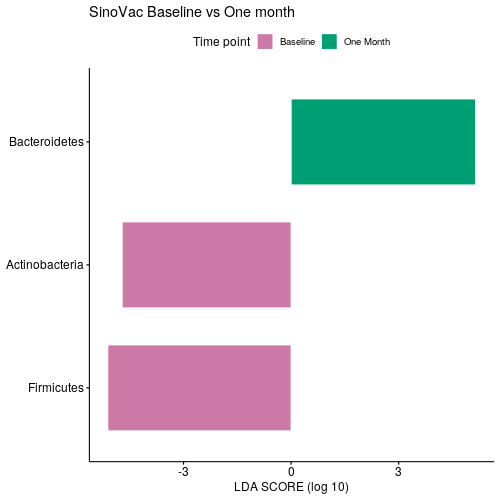

In [361]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Phylum", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "Time point") +
ylab("LDA SCORE (log 10)") +
ggtitle("SinoVac Baseline vs One month") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Baseline", "One Month"),
                  values=c("0"="#CC79A7", "1"="#009E73"))

print(p)
ggsave("../results/figures/V1/lefse/phylum_lefse_sinovac_timepoint.pdf", p, width=8, height=8)

In [ ]:
%%R
tax_p_lefse_summary <-
    tax_p_lefse %>% group_by(Phylum) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_p_enrichment <- tax_p_lefse_summary %>% right_join(lefse)
print(tax_p_enrichment)
write_tsv(tax_p_enrichment, "../results/tables/V1/lefse/tax_p_lefse_sinovac_timepoint_abun.tsv")

In [12]:
%%R
tax_s_lefse <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1) %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_2 <-
    tax_s_lefse %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)
    
tax_s_lefse_w <-
    tax_s_lefse_2 %>%
    bind_rows(
        tax_s_lefse %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_s_lefse_w, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.tsv")

[1] 484 138


In [13]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.lefse.in \
-c 2 -u 1 -o 1000000

In [14]:
!lefse_run.py \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.lefse.out.tsv

Number of significantly discriminative features: 21 ( 21 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 11
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [15]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 483 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


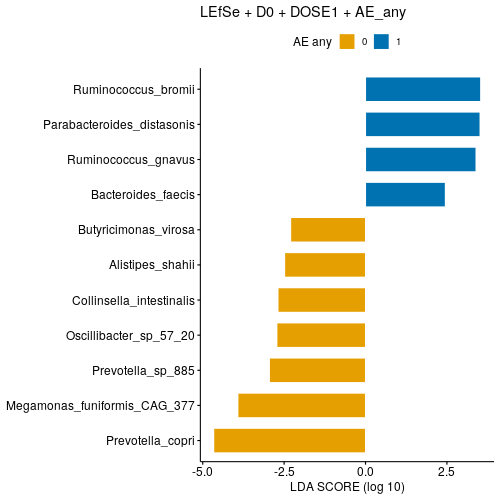

In [16]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ylab("LDA SCORE (log 10)") +
ggtitle("LEfSe + D0 + DOSE1 + AE_any") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE1_AE_any.pdf", p, width=8, height=8)

In [17]:
%%R
sum((tax_s_lefse %>% filter(Species=="Prevotella_copri"))$Abundance)

[1] 5.789803


In [18]:
%%R
median((tax_s_lefse %>% filter(Species=="Prevotella_copri"))$Abundance)

[1] 0


In [19]:
%%R
quantile((tax_s_lefse %>% filter(Species=="Prevotella_copri"))$Abundance)

       0%       25%       50%       75%      100% 
0.0000000 0.0000000 0.0000000 0.0000000 0.6275357 


In [20]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse %>% group_by(Species) %>%
    summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_abun.tsv")

Joining, by = "Species"
# A tibble: 11 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Alistipes_shah…    0.000384               0          0               0.000384
 2 Bacteroides_fa…    0                      0          0               0       
 3 Butyricimonas_…    0.000105               0          0               0.000105
 4 Collinsella_in…    0                      0          0               0       
 5 Megamonas_funi…    0                      0          0               0       
 6 Oscillibacter_…    0.000863               0          0               0.000863
 7 Parabacteroide…    0.00569                0          0.00236         0.00569 
 8 Prevotella_cop…    0                      0          0               0       
 9 Prevotella_sp_…    0                      0          0               0       
10 Ruminococcus_b…    0.00390                0          0        

In [21]:
%%R
tax_s_lefse <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==2) %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_2 <-
    tax_s_lefse %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)
    
tax_s_lefse_w <-
    tax_s_lefse_2 %>%
    bind_rows(
        tax_s_lefse %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_w))
#write_tsv(tax_s_lefse_ae_w, "../results/tables/T2409/tax_s_lefse_AE_w.tsv")
write_tsv(tax_s_lefse_w, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.tsv")

[1] 484 138


In [22]:
!lefse_format_input.py \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.lefse.out.tsv

Number of significantly discriminative features: 32 ( 32 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 17
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [23]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "p.value")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 483 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, p.value
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


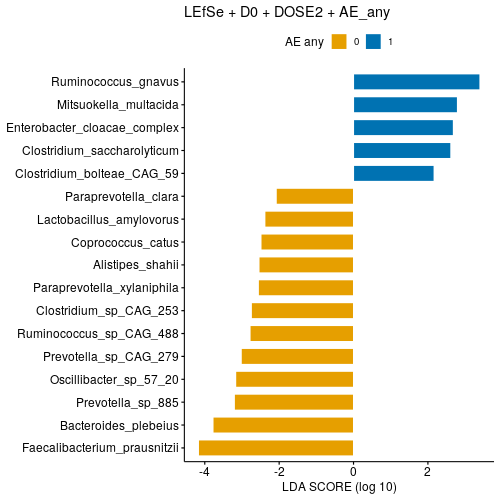

In [24]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",           # change fill color by mpg_level
    color = "white",            # Set bar border colors to white
    sort.val = "asc",           # Sort the value in ascending order
    sort.by.groups = TRUE,     # Don't sort inside each group
    ylab = FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ylab("LDA SCORE (log 10)") +
ggtitle("LEfSe + D0 + DOSE2 + AE_any") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE2_AE_any.pdf", p, width=8, height=8)

In [25]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse %>% group_by(Species) %>%
    summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_abun.tsv")

Joining, by = "Species"
# A tibble: 17 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Alistipes_shah…    0.000384               0           0              0.000384
 2 Bacteroides_pl…    0                      0           0              0       
 3 Clostridium_bo…    0                      0           0              0       
 4 Clostridium_sa…    0                      0           0              0       
 5 Clostridium_sp…    0                      0           0              0       
 6 Coprococcus_ca…    0.000740               0           0              0.000740
 7 Enterobacter_c…    0                      0           0              0       
 8 Faecalibacteri…    0.0414                 0           0.0186         0.0414  
 9 Lactobacillus_…    0                      0           0              0       
10 Mitsuokella_mu…    0                      0           0       

In [26]:
%%R
tax_s_lefse_ae_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1) %>%
    filter(Vac_Group=="BioNTech") %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_ae_biontech_2 <-
    tax_s_lefse_ae_biontech %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)
    
tax_s_lefse_ae_biontech_w <-
    tax_s_lefse_ae_biontech_2 %>%
    bind_rows(tax_s_lefse_ae_biontech %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

#write_tsv(tax_s_lefse_ae_biontech_w,
#          "../results/tables/T2409/tax_s_lefse_AE_biontech_w.tsv")
write_tsv(tax_s_lefse_ae_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.tsv")

In [27]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

In [28]:
!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 28 ( 28 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 20
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [29]:
%%R -w 700 -h 500
lefse_ae_biontech <- 
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


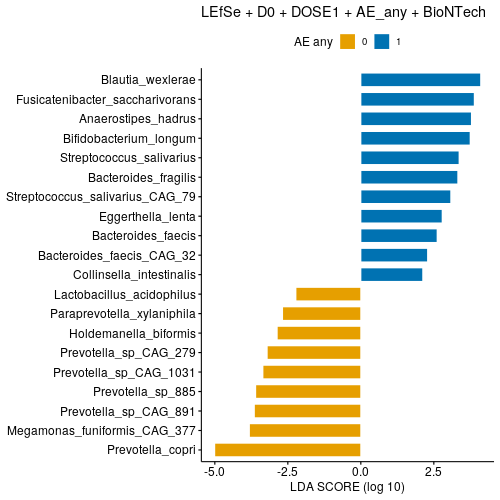

In [30]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse_ae_biontech, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ggtitle("LEfSe + D0 + DOSE1 + AE_any + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE1_AE_any_biontech.pdf", p, width=8, height=8)

In [31]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_ae_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse_ae_biontech)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 20 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Anaerostipes_h…    0.0100                 0         0.00479          0.0100  
 2 Bacteroides_fa…    0                      0         0                0       
 3 Bacteroides_fa…    0                      0         0                0       
 4 Bacteroides_fr…    0                      0         0                0       
 5 Bifidobacteriu…    0.00568                0         0.00145          0.00568 
 6 Blautia_wexler…    0.0218                 0         0.00932          0.0218  
 7 Collinsella_in…    0                      0         0                0       
 8 Eggerthella_le…    0.000207               0         0                0.000207
 9 Fusicatenibact…    0.0138                 0         0.00595          0.0138  
10 Holdemanella_b…    0                      0         0         

In [32]:
%%R
tax_s_lefse_ae_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==2) %>%
    filter(Vac_Group=="BioNTech") %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_ae_biontech_2 <-
    tax_s_lefse_ae_biontech %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)
    
tax_s_lefse_ae_biontech_w <-
    tax_s_lefse_ae_biontech_2 %>%
    bind_rows(tax_s_lefse_ae_biontech %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

#write_tsv(tax_s_lefse_ae_biontech_w,
#          "../results/tables/T2409/tax_s_lefse_AE_biontech_w.tsv")
write_tsv(tax_s_lefse_ae_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.tsv")

In [33]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 36 ( 36 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 25
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [34]:
%%R -w 700 -h 500
lefse_ae_biontech <- 
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


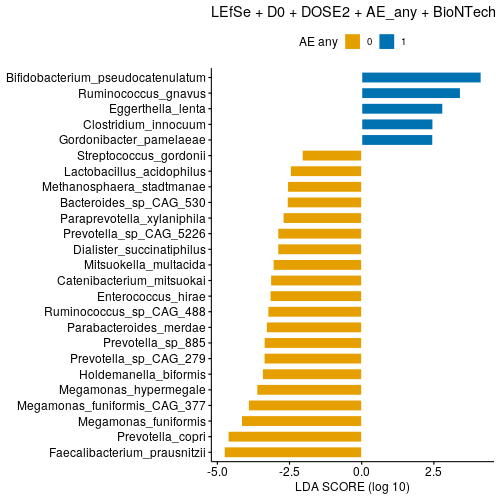

In [35]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse_ae_biontech, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ggtitle("LEfSe + D0 + DOSE2 + AE_any + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE2_AE_any_biontech.pdf", p, width=8, height=8)

In [36]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_ae_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse_ae_biontech)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 25 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Bacteroides_sp…   0                       0         0               0        
 2 Bifidobacteriu…   0.00615                 0         0.000143        0.00615  
 3 Catenibacteriu…   0                       0         0               0        
 4 Clostridium_in…   0.0000424               0         0               0.0000424
 5 Dialister_succ…   0                       0         0               0        
 6 Eggerthella_le…   0.000207                0         0               0.000207 
 7 Enterococcus_h…   0                       0         0               0        
 8 Faecalibacteri…   0.0408                  0         0.0175          0.0408   
 9 Gordonibacter_…   0.000165                0         0               0.000165 
10 Holdemanella_b…   0                       0         0         

In [37]:
%%R
tax_s_lefse_ae_sinovac <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(Vac_Group=="SinoVac") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1) %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_ae_sinovac_2 <-
    tax_s_lefse_ae_sinovac %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)

tax_s_lefse_ae_sinovac_w <-
    tax_s_lefse_ae_sinovac_2 %>%
    bind_rows(tax_s_lefse_ae_sinovac %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
#write_tsv(tax_s_lefse_ae_sinovac_w,
#          "../results/tables/T2409/tax_s_lefse_AE_sinovac_w.tsv")
write_tsv(tax_s_lefse_ae_sinovac_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.tsv")

In [38]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.lefse.out.tsv

Number of significantly discriminative features: 11 ( 11 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 9
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [39]:
%%R -w 700 -h 500
lefse_ae_sinovac <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_sinovac_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 348 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


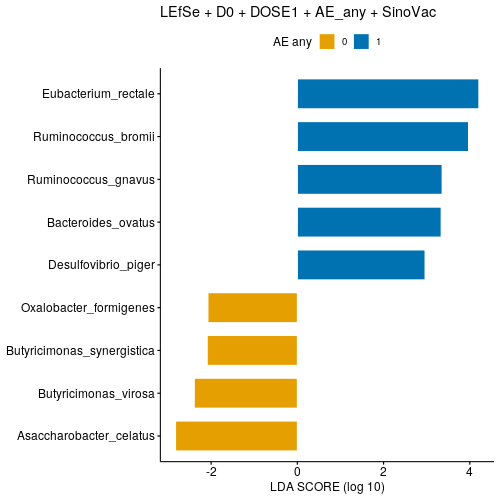

In [40]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse_ae_sinovac, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ggtitle("LEfSe + D0 + DOSE1 + AE_any + SinoVac") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE1_AE_any_sinovac.pdf", p, width=8, height=8)

In [41]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_ae_sinovac %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse_ae_sinovac)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_any_sinovac_abun.tsv")

Joining, by = "Species"
# A tibble: 9 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Asaccharobacter…   0.000734                0       0.00000766        0.000734 
2 Bacteroides_ova…   0.00318                 0       0.00121           0.00318  
3 Butyricimonas_s…   0                       0       0                 0        
4 Butyricimonas_v…   0.0000517               0       0                 0.0000517
5 Desulfovibrio_p…   0                       0       0                 0        
6 Eubacterium_rec…   0.0153                  0       0.000342          0.0153   
7 Oxalobacter_for…   0                       0       0                 0        
8 Ruminococcus_br…   0.0144                  0       0                 0.0144   
9 Ruminococcus_gn…   0.0000413               0       0                 0.0000413
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_1

In [42]:
%%R
tax_s_lefse_ae_sinovac <- tax_s_l_ae %>%
    filter(!is.na(AE_any)) %>%
    filter(Vac_Group=="SinoVac") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==2) %>%
    select(sample_id, Species, Abundance, AE_any) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_ae_sinovac_2 <-
    tax_s_lefse_ae_sinovac %>%
    select(sample_id, AE_any) %>%
    distinct() %>%
    mutate(Species="AE_any") %>%
    rename(Abundance=AE_any)

tax_s_lefse_ae_sinovac_w <-
    tax_s_lefse_ae_sinovac_2 %>%
    bind_rows(tax_s_lefse_ae_sinovac %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
#write_tsv(tax_s_lefse_ae_sinovac_w,
#          "../results/tables/T2409/tax_s_lefse_AE_sinovac_w.tsv")
write_tsv(tax_s_lefse_ae_sinovac_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.tsv")

In [43]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.lefse.out.tsv

Number of significantly discriminative features: 11 ( 11 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 5
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [44]:
%%R -w 700 -h 500
lefse_ae_sinovac <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_sinovac_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 348 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


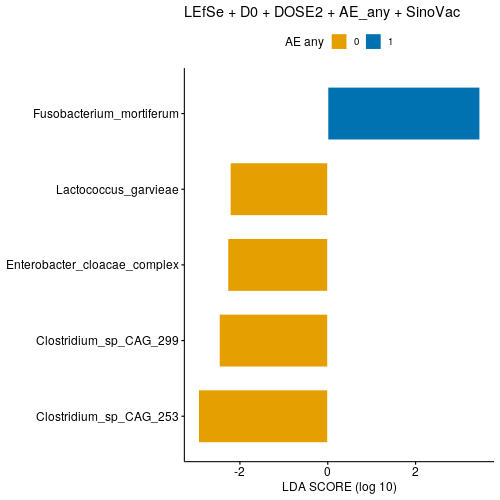

In [45]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse_ae_sinovac, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE any") +
ggtitle("LEfSe + D0 + DOSE2 + AE_any + SinoVac") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE2_AE_any_sinovac.pdf", p, width=8, height=8)

In [46]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_ae_sinovac %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse_ae_sinovac)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_any_sinovac_abun.tsv")

Joining, by = "Species"
# A tibble: 5 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Clostridium_sp_…           0               0                0                0
2 Clostridium_sp_…           0               0                0                0
3 Enterobacter_cl…           0               0                0                0
4 Fusobacterium_m…           0               0                0                0
5 Lactococcus_gar…           0               0                0                0
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, pvalue <chr>


In [416]:
%%R
dim(tax_s_l_ae %>%
    filter(!is.na(AE_Fever)) %>%
    filter(Vac_Group=="BioNTech") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1))

[1] 54700    96


In [419]:
%%R
tax_s_lefse_dose1_ae_fever_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_Fever)) %>%
    filter(Vac_Group=="BioNTech") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1) %>%
    select(sample_id, Species, Abundance, AE_Fever) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_dose1_ae_fever_biontech_2 <-
    tax_s_lefse_dose1_ae_fever_biontech %>%
    select(sample_id, AE_Fever) %>%
    distinct() %>%
    mutate(Species="AE_Fever") %>%
    rename(Abundance=AE_Fever)

tax_s_lefse_dose1_ae_fever_biontech_w <-
    tax_s_lefse_dose1_ae_fever_biontech_2 %>%
    bind_rows(tax_s_lefse_dose1_ae_fever_biontech %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_dose1_ae_fever_biontech_w))
write_tsv(tax_s_lefse_dose1_ae_fever_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.tsv")

[1] 459 101


In [420]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 39 ( 39 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 14
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [421]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


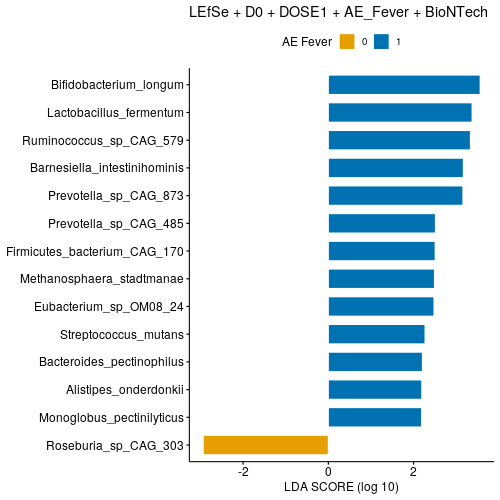

In [422]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE Fever") +
ggtitle("LEfSe + D0 + DOSE1 + AE_Fever + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE1_AE_fever_biontech.pdf", p, width=8, height=8)

In [423]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_dose1_ae_fever_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fever_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 14 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Alistipes_onde…     0                     0          0                0      
 2 Bacteroides_pe…     0                     0          0                0      
 3 Barnesiella_in…     0                     0          0                0      
 4 Bifidobacteriu…     0.00568               0          0.00145          0.00568
 5 Eubacterium_sp…     0                     0          0                0      
 6 Firmicutes_bac…     0                     0          0                0      
 7 Lactobacillus_…     0                     0          0                0      
 8 Methanosphaera…     0                     0          0                0      
 9 Monoglobus_pec…     0                     0          0                0      
10 Prevotella_sp_…     0                     0          0        

In [424]:
%%R
tax_s_lefse_dose2_ae_fever_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_Fever)) %>%
    filter(Vac_Group=="BioNTech") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==2) %>%
    select(sample_id, Species, Abundance, AE_Fever) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_dose2_ae_fever_biontech_2 <-
    tax_s_lefse_dose2_ae_fever_biontech %>%
    select(sample_id, AE_Fever) %>%
    distinct() %>%
    mutate(Species="AE_Fever") %>%
    rename(Abundance=AE_Fever)

tax_s_lefse_dose2_ae_fever_biontech_w <-
    tax_s_lefse_dose2_ae_fever_biontech_2 %>%
    bind_rows(tax_s_lefse_dose2_ae_fever_biontech %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_dose2_ae_fever_biontech_w))
write_tsv(tax_s_lefse_dose2_ae_fever_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.tsv")

[1] 459 101


In [425]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 29 ( 29 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 12
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [426]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


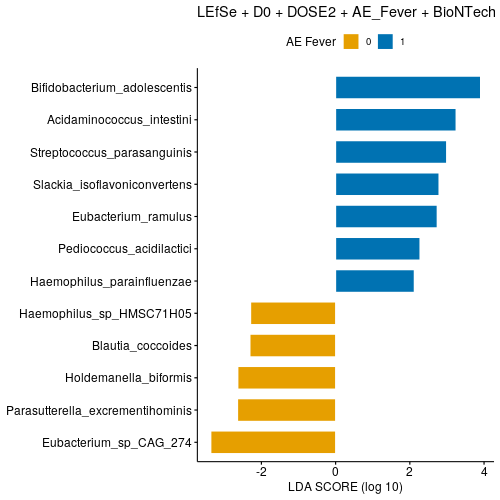

In [427]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE Fever") +
ggtitle("LEfSe + D0 + DOSE2 + AE_Fever + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE2_AE_fever_biontech.pdf", p, width=8, height=8)

In [428]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_dose2_ae_fever_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fever_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 12 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Acidaminococcu…   0                       0                0        0        
 2 Bifidobacteriu…   0.00894                 0                0        0.00894  
 3 Blautia_coccoi…   0                       0                0        0        
 4 Eubacterium_ra…   0.00126                 0                0        0.00126  
 5 Eubacterium_sp…   0                       0                0        0        
 6 Haemophilus_pa…   0                       0                0        0        
 7 Haemophilus_sp…   0                       0                0        0        
 8 Holdemanella_b…   0                       0                0        0        
 9 Parasutterella…   0                       0                0        0        
10 Pediococcus_ac…   0                       0                0  

In [431]:
%%R
tax_s_lefse_dose1_ae_fatigue_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_Fatigue)) %>%
    filter(Vac_Group=="BioNTech") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==1) %>%
    select(sample_id, Species, Abundance, AE_Fatigue) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_dose1_ae_fatigue_biontech_2 <-
    tax_s_lefse_dose1_ae_fatigue_biontech %>%
    select(sample_id, AE_Fatigue) %>%
    distinct() %>%
    mutate(Species="AE_Fatigue") %>%
    rename(Abundance=AE_Fatigue)

tax_s_lefse_dose1_ae_fatigue_biontech_w <-
    tax_s_lefse_dose1_ae_fatigue_biontech_2 %>%
    bind_rows(tax_s_lefse_dose1_ae_fatigue_biontech %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_dose1_ae_fatigue_biontech_w))
write_tsv(tax_s_lefse_dose1_ae_fatigue_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.tsv")

[1] 459 101


In [432]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 14 ( 14 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 8
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [433]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


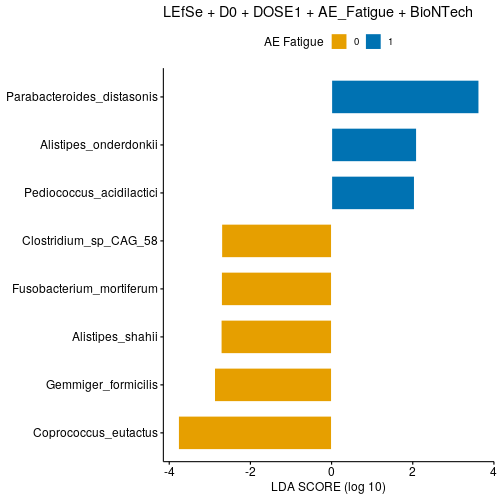

In [434]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE Fatigue") +
ggtitle("LEfSe + D0 + DOSE1 + AE_Fatigue + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE1_AE_fatigue_biontech.pdf", p, width=8, height=8)

In [435]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_dose1_ae_fatigue_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE1_AE_fatigue_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 8 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Alistipes_onder…    0                      0          0               0       
2 Alistipes_shahii    0.000304               0          0               0.000304
3 Clostridium_sp_…    0                      0          0               0       
4 Coprococcus_eut…    0                      0          0               0       
5 Fusobacterium_m…    0                      0          0               0       
6 Gemmiger_formic…    0.00132                0          0               0.00132 
7 Parabacteroides…    0.00649                0          0.00243         0.00649 
8 Pediococcus_aci…    0                      0          0               0       
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, pvalue <chr>


In [436]:
%%R
tax_s_lefse_dose2_ae_fatigue_biontech <- tax_s_l_ae %>%
    filter(!is.na(AE_Fatigue)) %>%
    filter(Vac_Group=="BioNTech") %>%
    filter(TimePoint=="D0") %>%
    filter(VAC_DOSE==2) %>%
    select(sample_id, Species, Abundance, AE_Fatigue) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_dose2_ae_fatigue_biontech_2 <-
    tax_s_lefse_dose1_ae_fatigue_biontech %>%
    select(sample_id, AE_Fatigue) %>%
    distinct() %>%
    mutate(Species="AE_Fatigue") %>%
    rename(Abundance=AE_Fatigue)

tax_s_lefse_dose2_ae_fatigue_biontech_w <-
    tax_s_lefse_dose2_ae_fatigue_biontech_2 %>%
    bind_rows(tax_s_lefse_dose1_ae_fatigue_biontech %>%
        select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_lefse_dose2_ae_fatigue_biontech_w))
write_tsv(tax_s_lefse_dose2_ae_fatigue_biontech_w,
          "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.tsv")

[1] 459 101


In [437]:
!lefse_format_input.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.tsv \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.lefse.in  -c 2 -u 1 -o 1000000

!lefse_run.py ../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.lefse.in \
../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.lefse.out.tsv

Number of significantly discriminative features: 14 ( 14 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 8
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [438]:
%%R -w 700 -h 500
lefse <-
    read_tsv("../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_w.lefse.out.tsv",
             col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 458 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


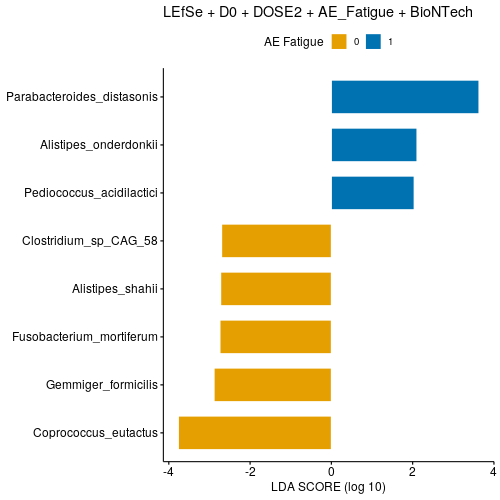

In [439]:
%%R -w 500 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "AE Fatigue") +
ggtitle("LEfSe + D0 + DOSE2 + AE_Fatigue + BioNTech") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("0", "1"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("../results/figures/V1/lefse/species_lefse_D0_DOSE2_AE_fatigue_biontech.pdf", p, width=8, height=8)

In [440]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_dose2_ae_fatigue_biontech %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "../results/tables/V1/lefse/tax_s_lefse_D0_DOSE2_AE_fatigue_biontech_abun.tsv")

Joining, by = "Species"
# A tibble: 8 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Alistipes_onder…    0                      0          0               0       
2 Alistipes_shahii    0.000304               0          0               0.000304
3 Clostridium_sp_…    0                      0          0               0       
4 Coprococcus_eut…    0                      0          0               0       
5 Fusobacterium_m…    0                      0          0               0       
6 Gemmiger_formic…    0.00132                0          0               0.00132 
7 Parabacteroides…    0.00649                0          0.00243         0.00649 
8 Pediococcus_aci…    0                      0          0               0       
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, pvalue <chr>


### Species with immune binary group among D0 OWOB population

In [47]:
%%R
samples_metadata_ae$OWOB

  [1]  0  0  0  0  0  1  1  0  0  0  0  1  1  0  0  0  0  1  1  0  0  0  0  0  0
 [26]  0  0  0  0  1  1  1  1  0  0  1  1  1  1  0  0  0  0  0  0  1  1  0  0  0
 [51]  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  0  0  1  1  0  0  0  0
 [76]  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  1
[101]  1  0  0  0  0  1  1  0  0  1  1  1  1  0  0  1  1  0  0  0  0  1  1  1  1
[126]  0  0  0  0  1  1  0  0  1  1  1  1  1  1  0  0  1  1  0  0  1  1  1  1  0
[151]  0  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  1  1  1  1
[176]  0  0  1  1  0  0  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
[201]  0  0  0  0  0  1  1  0  0  0  0  0  0  1  1  1  1  0  0  1  1  1  1  1  1
[226]  0  0  0  0  1  1  0  0  0  0  0  0  1  1  0  0  1  1  0  0  1  1  0  0 NA
[251] NA  1  1  1  1  0  0  0  0  0  0  1  1  1  1  0  0  0  0  0  0  1  1  1  1


In [48]:
%%R
samples_metadata_owob_group <-
    samples_metadata_ae %>%
    filter(TimePoint=="D0") %>%
    select(sample_id, ID, Vac_Group, OWOB, BMI,
           AUC_100_12800, M1_sVNT_10, M1_sVNT_200, M1_sVNT,
           RBD_binary_group, sVNT_binary_group, sVNT_60percent_binary_group) %>%
    distinct() %>%
    filter(!is.na(BMI)) %>%
    group_by(OWOB) %>%
    mutate(RBD_median=median(AUC_100_12800)) %>%
    mutate(RBD_median_group=case_when(
        AUC_100_12800 >= RBD_median ~ 1,
        AUC_100_12800 < RBD_median ~ 0))

In [49]:
%%R
dim(samples_metadata_owob_group)

[1] 137  14


In [50]:
%%R
tax_s_l_owob <- tax_s_l %>% right_join(samples_metadata_owob_group)

Joining, by = "sample_id"


In [51]:
%%R
dim(tax_s_l_owob)

[1] 74939    17


In [52]:
%%R
137 * 547

[1] 74939


## Extended Figure 7

#### OWOB1 and sVNT 60percent SinoVac

In [96]:
%%R
tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group <-
    tax_s_l_owob %>%
    filter(OWOB==1) %>%
    filter(Vac_Group=="SinoVac") %>%
    select(sample_id, Species, Abundance, sVNT_60percent_binary_group) %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()

tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_2 <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>%
    select(sample_id, sVNT_60percent_binary_group) %>%
    distinct() %>%
    mutate(Species="sVNT_60percent_binary_group") %>%
    rename(Abundance=sVNT_60percent_binary_group) %>%
    mutate(Abundance=as.numeric(Abundance))

tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_2 %>%
    bind_rows(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)
    
print(dim(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w))
write_tsv(tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group_w,
          "tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.tsv")

[1] 246  16


In [97]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.tsv \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.in  \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.in \
tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.out.tsv

Number of significantly discriminative features: 9 ( 9 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 6
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [98]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_w.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==0 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("0", "1")))

Rows: 245 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


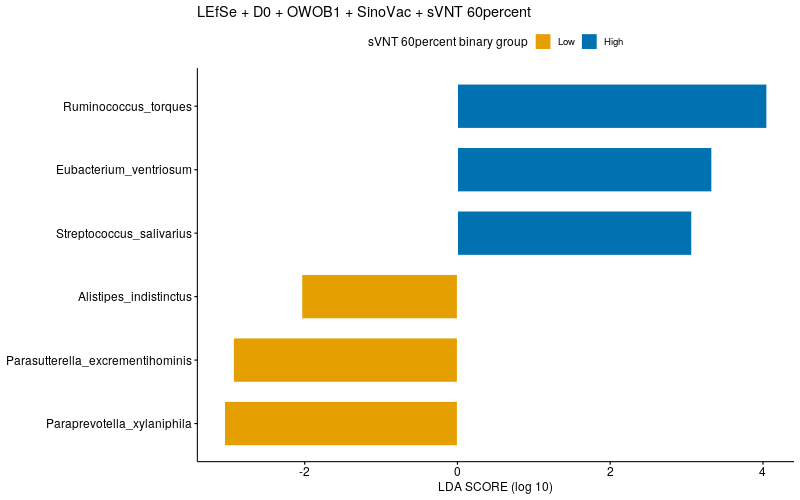

In [99]:
%%R -w 800 -h 500
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT 60percent binary group") +
ggtitle("LEfSe + D0 + OWOB1 + SinoVac + sVNT 60percent") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group.pdf", p, width=8, height=8)

In [100]:
%%R
tax_s_lefse_summary <-
    tax_s_l_d0_owob_1_sinovac_sVNT_60percent_binary_group %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_OWOB1_sinovac_sVNT_60percent_binary_group_abun.tsv")

Joining, by = "Species"
# A tibble: 6 × 11
  Species          abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
  <chr>                  <dbl>           <dbl>            <dbl>            <dbl>
1 Alistipes_indis…  0.00000821               0        0               0.00000821
2 Eubacterium_ven…  0.00125                  0        0.0000945       0.00125   
3 Paraprevotella_…  0.000201                 0        0               0.000201  
4 Parasutterella_…  0                        0        0               0         
5 Ruminococcus_to…  0.00821                  0        0.00127         0.00821   
6 Streptococcus_s…  0.000573                 0        0.000187        0.000573  
# … with 6 more variables: abun_quartile_75 <dbl>, abun_quartile_100 <dbl>,
#   v1 <dbl>, group <fct>, LDA_score <dbl>, pvalue <chr>


### Species with Immune Binary group among all D0 people

In [ ]:
%%R
dim(tax_s_l_owob)

[1] 74939    17


In [102]:
%%R
547 * 137

[1] 74939


In [301]:
%%R
dim(tax_s_l_272S %>% filter(TimePoint=="D0"))

[1] 75486    60


In [302]:
%%R
138 * 547

[1] 75486


In [165]:
%%R
lefse_py_bnt <- read_excel("data/Bivariate_analysis_GLM_clusters-Sep-28-2021.xlsx", sheet=6)

R[write to console]: New names:
* `` -> ...2



In [166]:
%%R
lefse_py_bnt %>% filter(!is.na(Enrichment)) %>% select(Enrichment) %>% as.list()

$Enrichment
 [1] 2 2 1 1 2 1 2 2 2 2 2 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2 2 1 2 1 2 2 1 2 1 1 2 1
[39] 1 1 1 1 2 1 1 1 1 1 1 1 1



In [167]:
%%R
lefse_py_bnt <-
    lefse_py_bnt %>%
filter(!is.na(Enrichment)) %>%
mutate(`LDA score`=case_when(
    Enrichment==1 ~ (-`LDA score`),
    TRUE ~ `LDA score`)) %>%
mutate(Enrichment=factor(Enrichment, levels=c("1", "2")))

In [168]:
%%R
lefse_py_bnt

# A tibble: 51 × 5
   Species                            ...2 Enrichment `LDA score` `p value`     
   <chr>                             <dbl> <fct>            <dbl> <chr>         
 1 Bifidobacterium_longum             4.21 2                 3.74 0.04388925031…
 2 Bifidobacterium_pseudocatenulatum  4.52 2                 4.07 0.02431493387…
 3 Olsenella_scatoligenes             3.18 1                -2.72 0.00124721278…
 4 Collinsella_aerofaciens            4.55 1                -3.87 0.03002901031…
 5 Eggerthella_lenta                  3.18 2                 2.73 0.00852576215…
 6 Bacteroides_coprophilus            3.61 1                -3.23 0.00136154467…
 7 Bacteroides_finegoldii             2.99 2                 2.32 0.02989981221…
 8 Bacteroides_fragilis               3.69 2                 3.34 0.03138840955…
 9 Bacteroides_ovatus                 4.07 2                 3.66 0.00479100839…
10 Bacteroides_thetaiotaomicron       3.94 2                 3.49 0.01782624331…
# … with 

In [169]:
%%R
lefse_py_bnt$Enrichment

 [1] 2 2 1 1 2 1 2 2 2 2 2 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2 2 1 2 1 2 2 1 2 1 1 2 1
[39] 1 1 1 1 2 1 1 1 1 1 1 1 1
Levels: 1 2


## Extended Figure 9d and 9h

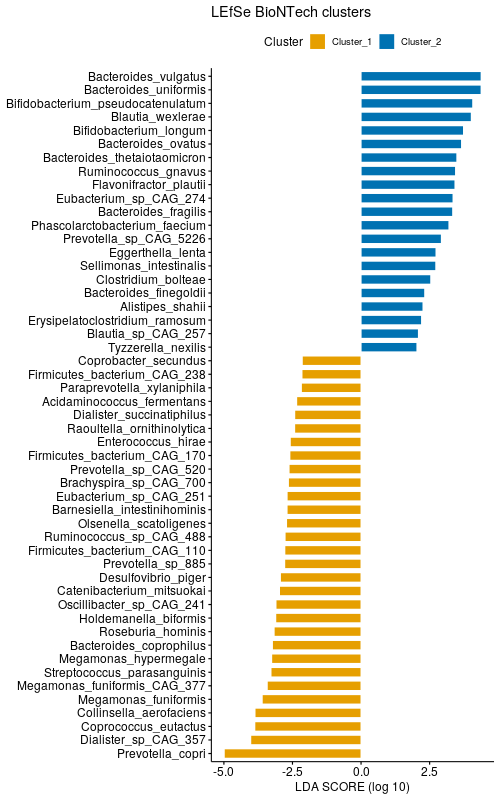

In [170]:
%%R -w 500 -h 800
p <- ggbarplot(lefse_py_bnt, x = "Species", y = "LDA score",
          fill = "Enrichment",           # change fill color by mpg_level
          color = "white",            # Set bar border colors to white
          sort.val = "asc",           # Sort the value in ascending order
          sort.by.groups = TRUE,     # Don't sort inside each group
          rotate = TRUE,
          ylab=FALSE,
          legend.title = "Cluster") + ggtitle("LEfSe BioNTech clusters")  +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c(1, 2), labels=c("Cluster_1", "Cluster_2"),
                  values=c("2"="#0072B2", "1"="#E69F00"))
#scale_y_log10() #+
#scale_fill_manual(name = "RBD group", breaks=c("0", "1"), labels=c("Low", "Higher"))

print(p)
ggsave("tables/lefse/species_lefse_biontech_cluster.pdf", p, width=8, height=10)

#### SinoVac

In [171]:
%%R
lefse_py_snv <- read_excel("data/Bivariate_analysis_GLM_clusters-Sep-28-2021.xlsx", sheet=7)

R[write to console]: New names:
* `` -> ...2



In [172]:
%%R
lefse_py_snv <-
    lefse_py_snv %>%
filter(!is.na(Enrichment)) %>%
mutate(`LDA score`=case_when(
    Enrichment==1 ~ (-`LDA score`),
    TRUE ~ `LDA score`)) %>%
mutate(Enrichment=factor(Enrichment, levels=c("1", "2")))

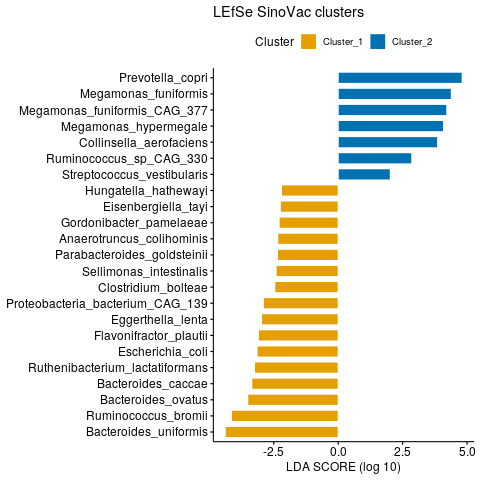

In [173]:
%%R
p <- ggbarplot(lefse_py_snv, x = "Species", y = "LDA score",
          fill = "Enrichment",           # change fill color by mpg_level
          color = "white",            # Set bar border colors to white
          sort.val = "asc",           # Sort the value in ascending order
          sort.by.groups = TRUE,     # Don't sort inside each group
          ylab = FALSE,
          rotate = TRUE,
          legend.title = "Cluster") + ggtitle("LEfSe SinoVac clusters")  +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c(1, 2), labels=c("Cluster_1", "Cluster_2"),
                  values=c("2"="#0072B2", "1"="#E69F00"))
#scale_y_log10() #+
#scale_fill_manual(name = "RBD group", breaks=c("0", "1"), labels=c("Low", "Higher"))

print(p)
ggsave("figures/species_lefse_sinovac_cluster.pdf", p, width=8, height=8)

#### Redo lefse and cluster

In [174]:
%%R

samples_metadata <- read_tsv("metadata/samples_metadata_imm_272S.tsv")

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [175]:
%%R
tax_s_l_metadata <-
    tax_s_l %>%
    inner_join(samples_metadata)
    
print(dim(tax_s_l_metadata))

Joining, by = "sample_id"
[1] 148784     60


In [176]:
%%R

547 * 272

[1] 148784


##### BioNTech

In [177]:
%%R
tax_s_lefse_biontech_cluster <-
    tax_s_l_metadata %>%
    filter(TimePoint=="D0" & Vac_Group=="BioNTech") %>%
    select(sample_id, Species, Abundance, BNT_jsd_cluster2) %>%
    distinct() %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_biontech_cluster_2 <-
    tax_s_lefse_biontech_cluster %>%
    select(sample_id, BNT_jsd_cluster2) %>%
    distinct() %>%
    mutate(Species="JSD_Cluster") %>%
    rename(Abundance=BNT_jsd_cluster2)
    
tax_s_lefse_biontech_cluster_w <-
    tax_s_lefse_biontech_cluster_2 %>%
    bind_rows(tax_s_lefse_biontech_cluster %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

print(dim(tax_s_lefse_biontech_cluster_w))
write_tsv(tax_s_lefse_biontech_cluster_w, "tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.tsv")

[1] 464 102


In [178]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.tsv \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.in \
tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.out.tsv

Number of significantly discriminative features: 77 ( 77 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 51
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [203]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==1 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("1", "2")))

Rows: 463 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


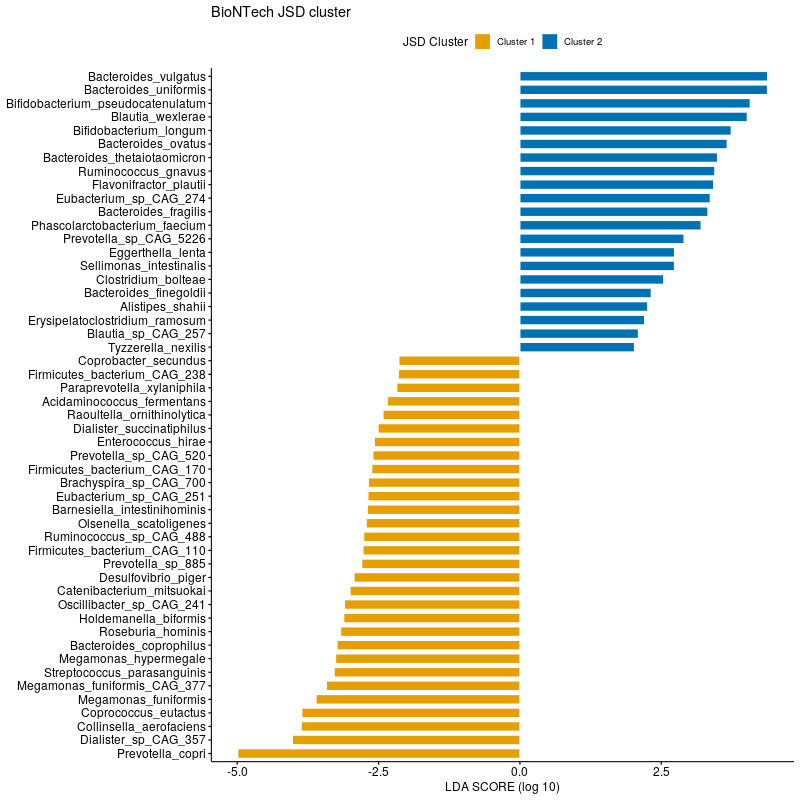

In [205]:
%%R -w 800 -h 800
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "JSD Cluster") +
ggtitle("BioNTech JSD cluster") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("1", "2"), labels=c("Cluster 1", "Cluster 2"),
                  values=c("1"="#E69F00", "2"="#0072B2"))

print(p)
ggsave("figures/species_lefse_D0_biontech_JSD_cluster.pdf", p, width=8, height=12)

In [181]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_biontech_cluster %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_biontech_JSD_cluster_abun.tsv")

Joining, by = "Species"
# A tibble: 51 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Acidaminococcu…    0                      0         0                0       
 2 Alistipes_shah…    0.000362               0         0                0.000362
 3 Bacteroides_co…    0                      0         0                0       
 4 Bacteroides_fi…    0                      0         0                0       
 5 Bacteroides_fr…    0                      0         0                0       
 6 Bacteroides_ov…    0.00280                0         0.000655         0.00280 
 7 Bacteroides_th…    0.00252                0         0.00101          0.00252 
 8 Bacteroides_un…    0.0281                 0         0.00695          0.0281  
 9 Bacteroides_vu…    0.0213                 0         0.00471          0.0213  
10 Barnesiella_in…    0                      0         0         

##### SinoVac

In [441]:
%%R
tax_s_lefse_sinovac_cluster <-
    tax_s_l_metadata %>%
    filter(TimePoint=="D0" & Vac_Group=="SinoVac") %>%
    select(sample_id, Species, Abundance, SNV_jsd_cluster2) %>%
    distinct() %>%
    group_by(Species) %>%
    mutate(Species_abun_sum=sum(Abundance)) %>%
    filter(!Species_abun_sum<=0.0) %>%
    select(-Species_abun_sum) %>%
    ungroup()
    
tax_s_lefse_sinovac_cluster_2 <-
    tax_s_lefse_sinovac_cluster %>%
    select(sample_id, SNV_jsd_cluster2) %>%
    distinct() %>%
    mutate(Species="JSD_Cluster") %>%
    rename(Abundance=SNV_jsd_cluster2)
    
tax_s_lefse_sinovac_cluster_w <-
    tax_s_lefse_sinovac_cluster_2 %>%
    bind_rows(tax_s_lefse_sinovac_cluster %>%
    select(sample_id, Species, Abundance)) %>%
    pivot_wider(names_from=sample_id, values_from=Abundance)

print(dim(tax_s_lefse_sinovac_cluster_w))
write_tsv(tax_s_lefse_sinovac_cluster_w, "tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.tsv")

[1] 349  38


In [442]:
!lefse_format_input.py \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.tsv \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.in \
-c 2 -u 1 -o 1000000

!lefse_run.py \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.in \
tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.out.tsv

Number of significantly discriminative features: 28 ( 28 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 23
R[write to console]: Warning messages:

R[write to console]: 1: package ‘survival’ was built under R version 4.0.5 

R[write to console]: 2: package ‘mvtnorm’ was built under R version 4.0.5 

R[write to console]: 3: package ‘modeltools’ was built under R version 4.0.5 



In [443]:
%%R
lefse <- read_tsv("tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster.lefse.out.tsv",
                  col_names=c("Species", "v1", "group", "LDA_score", "pvalue")) %>%
filter(!is.na(group)) %>%
mutate(LDA_score=case_when(
    group==1 ~ (-LDA_score),
    TRUE ~ LDA_score)) %>%
mutate(group=factor(group, levels=c("1", "2")))

Rows: 348 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Species, pvalue
dbl (3): v1, group, LDA_score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


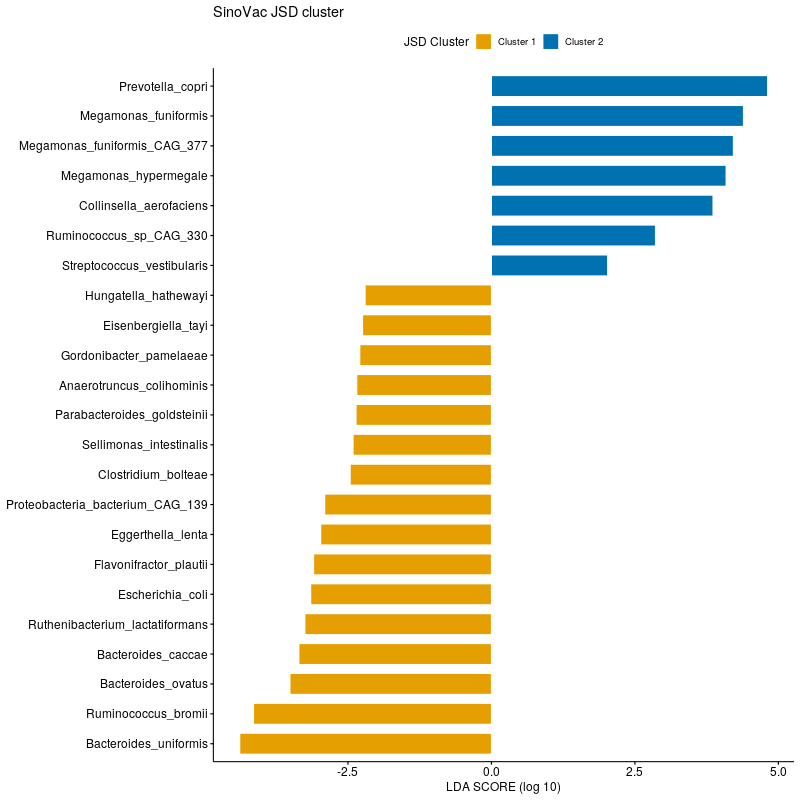

In [444]:
%%R -w 800 -h 800
p <- ggbarplot(
    lefse, x = "Species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "JSD Cluster") +
ggtitle("SinoVac JSD cluster") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("1", "2"), labels=c("Cluster 1", "Cluster 2"),
                  values=c("1"="#E69F00", "2"="#0072B2"))

print(p)
ggsave("tables/lefse/species_lefse_D0_sinovac_JSD_cluster.pdf", p, width=8, height=8)

In [445]:
%%R
tax_s_lefse_summary <-
    tax_s_lefse_sinovac_cluster %>% group_by(Species) %>%
        summarise(abun_median=median(Abundance),
              abun_quartile_0=quantile(Abundance, 0.00),
              abun_quartile_25=quantile(Abundance, 0.25),
              abun_quartile_50=quantile(Abundance, 0.50),
              abun_quartile_75=quantile(Abundance, 0.75),
              abun_quartile_100=quantile(Abundance, 1.00))
tax_s_enrichment <- tax_s_lefse_summary %>% right_join(lefse)
print(tax_s_enrichment)
write_tsv(tax_s_enrichment, "tables/lefse/tax_s_lefse_D0_sinovac_JSD_cluster_abun.tsv")

Joining, by = "Species"
# A tibble: 23 × 11
   Species         abun_median abun_quartile_0 abun_quartile_25 abun_quartile_50
   <chr>                 <dbl>           <dbl>            <dbl>            <dbl>
 1 Anaerotruncus_…  0.00000594       0                0               0.00000594
 2 Bacteroides_ca…  0.00292          0                0               0.00292   
 3 Bacteroides_ov…  0.00318          0                0.00121         0.00318   
 4 Bacteroides_un…  0.0335           0.000939         0.0158          0.0335    
 5 Clostridium_bo…  0.000126         0                0               0.000126  
 6 Collinsella_ae…  0.00661          0                0.0000740       0.00661   
 7 Eggerthella_le…  0.000355         0                0               0.000355  
 8 Eisenbergiella…  0                0                0               0         
 9 Escherichia_co…  0.000220         0                0               0.000220  
10 Flavonifractor…  0.00187          0.0000472        0.000966   

### M1

In [446]:
%%R
lefse_res_df_SNV_sVNT_60perc_M1 <-
    read_excel("data/pengye_LEfSe_results.xlsx", sheet=1) %>%
    filter(!is.na(group)) %>%
    mutate(LDA_score=case_when(
        group==0 ~ (-LDA_score),
        TRUE ~ LDA_score
    )) %>%
    mutate(group=factor(group, levels=c(0, 1)))

lefse_res_df_BNT_sVNT_Q1_M1 <-
    read_excel("data/pengye_LEfSe_results.xlsx", sheet=2) %>%
    filter(!is.na(group)) %>%
    mutate(LDA_score=case_when(
        group==0 ~ (-LDA_score),
        TRUE ~ LDA_score
    )) %>%
    mutate(group=factor(group, levels=c(0, 1)))

## Extended Figure 2a

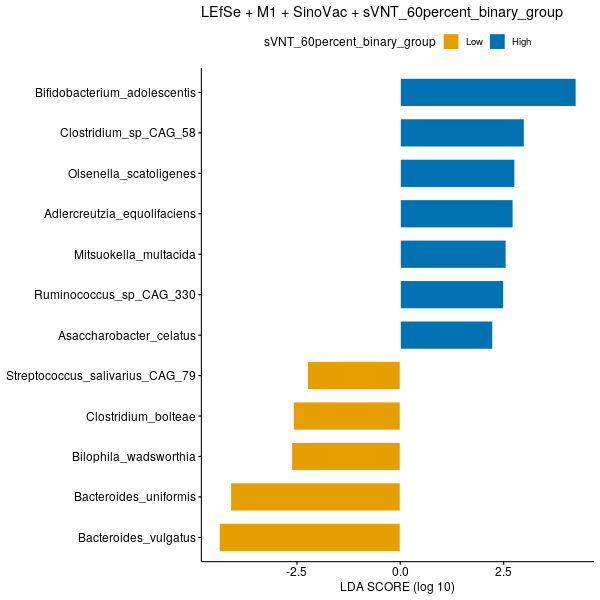

In [447]:
%%R -w 600 -h 600
p <- ggbarplot(
    lefse_res_df_SNV_sVNT_60perc_M1, x = "species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT_60percent_binary_group") +
ggtitle("LEfSe + M1 + SinoVac + sVNT_60percent_binary_group") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_M1_sinovac_sVNT_60percent_binary_group_py.pdf",
       p, width=8, height=8)

## Extended Figure 2b

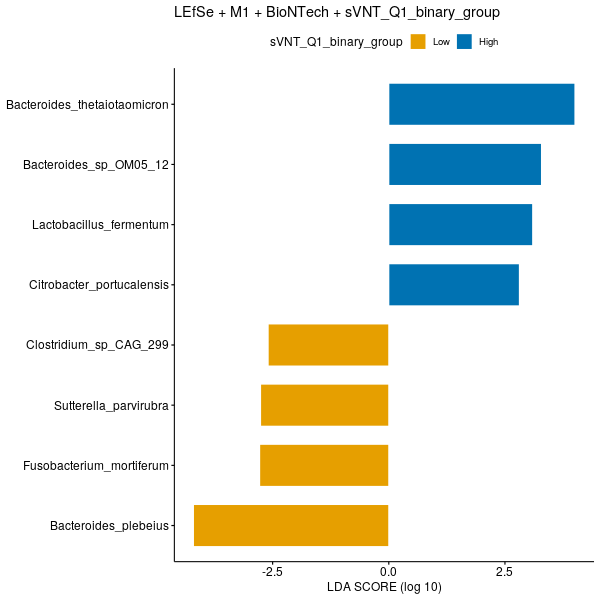

In [448]:
%%R -w 600 -h 600
#lefse_res_df_SNV_sVNT_60perc_M1
#lefse_res_df_BNT_sVNT_Q1_M1
#lefse_res_df_BNT_sVNT200_Q1
#lefse_res_df_SNV_sVNT10_60perc
#lefse_res_df_BNT_DOSE1_AE_2_or_more
#lefse_res_df_BNT_DOSE2_AE_2_or_more
#lefse_res_df_SNV_Dose1_AE
#lefse_res_df_SNV_Dose2_AE
p <- ggbarplot(
    lefse_res_df_BNT_sVNT_Q1_M1, x = "species", y = "LDA_score",
    fill = "group",
    color = "white",
    sort.val = "asc",
    sort.by.groups = TRUE,
    ylab= FALSE,
    rotate = TRUE,
    legend.title = "sVNT_Q1_binary_group") +
ggtitle("LEfSe + M1 + BioNTech + sVNT_Q1_binary_group") +
ylab("LDA SCORE (log 10)") +
scale_fill_manual(breaks=c("0", "1"), labels=c("Low", "High"),
                  values=c("0"="#E69F00", "1"="#0072B2"))

print(p)
ggsave("figures/species_lefse_M1_biontech_sVNT_binary_group_py.pdf",
       p, width=8, height=8)